In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import os
from os import listdir
# common visualizing tools
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
plt.style.use('ggplot')
# CNN layers and the Deep Learning model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam,RMSprop
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_curve
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
# post processing and model evaluation
from scipy.misc import imread, imresize
from sklearn.metrics import confusion_matrix ,classification_report
from sklearn import metrics
# splitting tool for the validation set
from sklearn.model_selection import train_test_split

# to block unnecesarry warnings for updates etc.
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/examples/examples/Examples/"))

# Any results you write to the current directory are saved as output.

['example_8.JPG', 'example_0.JPG', 'example_9.JPG', 'example_5.JPG', 'example_6.JPG', 'example_3.JPG', 'example_2.JPG', 'example_1.JPG', 'example_4.JPG', 'example_7.JPG']


Using TensorFlow backend.


**variables initialization**

In [2]:
img_size = 64 #the size of the image to be resized with
grayscale_images = False #set true for RGB
num_class = 10 #num of classes to be classified
test_size = 0.2 #percent of test size 
dataset_path = "../input/turkish-digit/dataset/Dataset/" #training data directory
os.listdir(dataset_path)
channels = 3 #initialize with 1 if gray scale set True


****functions to get the images from the given path,resize it and label it****

In [3]:
def get_img(data_path):
    # Getting image array from path:
    img = imread(data_path)
    img = imresize(img, (img_size, img_size,  channels))
    return img

In [4]:
def get_dataset(dataset_path):
    # Getting all data from data path:
    try:
        X = np.load('npy_dataset/X.npy')
        Y = np.load('npy_dataset/Y.npy')
    except:
        labels = listdir(dataset_path) # Geting labels
        X = []
        Y = []
        for i, label in enumerate(labels):
            datas_path = dataset_path+'/'+label
            for data in listdir(datas_path):
                img = get_img(datas_path+'/'+data)
                X.append(img)
                Y.append(label)
        # Create dateset:
        X = 1-np.array(X).astype('float32')/255. #here we normalize the images
        Y = np.array(Y).astype('float32')
        #Y = to_categorical(Y, num_class) 
        if not os.path.exists('npy_dataset/'):
            os.makedirs('npy_dataset/')
        np.save('npy_dataset/X.npy', X)
        np.save('npy_dataset/Y.npy', Y)
    X, X_test, Y, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X, X_test, Y, Y_test


In [5]:
X, X_test, Y, Y_test = get_dataset(dataset_path) #calling the function

**reshaping training arrays **

In [6]:
X = X.reshape(X.shape[0], img_size, img_size,channels)
X_test = X_test.reshape(X_test.shape[0], img_size, img_size,channels)
Y = Y.reshape(Y.shape[0],1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

here the count plot shows the frequancy of each label so we can determine the balancing of the data , it is clear that the data is almost balanced all labels ranged from 150 to 175 .

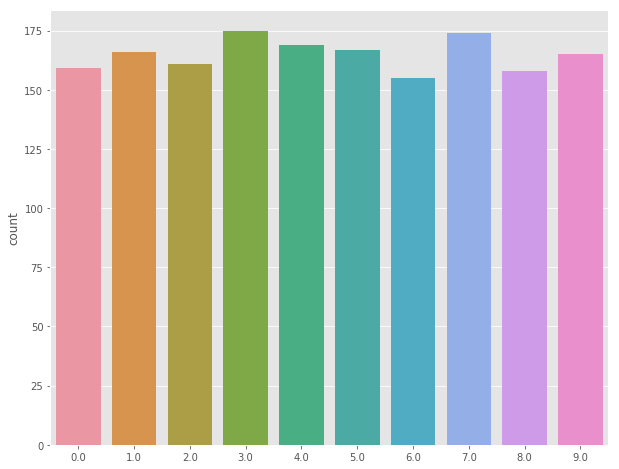

In [7]:
plt.figure(figsize=(10,8))
sns.countplot(x=Y[:,0])

**structuring the model**
my CNN architechture is In -> [Conv2D->relu*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out(softmax)

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (5,5), activation='relu',padding='same', input_shape=(img_size, img_size, 3)),
  tf.keras.layers.Conv2D(32,(5,5), activation='relu',padding='same'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout((0.25)),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Dropout((0.25)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout((0.5)),
  tf.keras.layers.Dense(10, activation='softmax')
])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


here to set the optimizer and the loss function i have tried Adam and RMSprop optimizers and they are almost gave the same accuracy in our case ,also i used sparse_categorical_crossentropy loss as the data is categorical and the labels are labeled not one hot encoded

In [9]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer = tf.keras.optimizers.Adam( epsilon=1e-08), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**data augmantation**

i have played with data augmentation so as to get the best accuracy here is what i have got

In [10]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly shift images horizontally (fraction of total width)
train_datagen.fit(X)

**fitting and trainig the model**
to train faster i used batch_size , not to train all the data all at once every epoch ,then i used learning rate decay and it is very effective at late epochs 

In [11]:
batch_size = 128
history = model.fit_generator(train_datagen.flow(X,Y,batch_size = batch_size),
                              epochs=70,
                              verbose=2,
                              steps_per_epoch=X.shape[0] // batch_size,
                              validation_data=(X_test,Y_test),
                              callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)])

Epoch 1/70
413/413 [==============================] - 0s 482us/sample - loss: 2.3097 - acc: 0.1380
 - 3s - loss: 2.8571 - acc: 0.1013 - val_loss: 2.3113 - val_acc: 0.1380
Epoch 2/70
413/413 [==============================] - 0s 134us/sample - loss: 2.2658 - acc: 0.1889
 - 2s - loss: 2.3027 - acc: 0.1225 - val_loss: 2.2681 - val_acc: 0.1889
Epoch 3/70
413/413 [==============================] - 0s 144us/sample - loss: 2.0025 - acc: 0.3705
 - 2s - loss: 2.2553 - acc: 0.1850 - val_loss: 2.0186 - val_acc: 0.3705
Epoch 4/70
413/413 [==============================] - 0s 158us/sample - loss: 1.7502 - acc: 0.4334
 - 2s - loss: 2.2134 - acc: 0.2189 - val_loss: 1.7383 - val_acc: 0.4334
Epoch 5/70
413/413 [==============================] - 0s 154us/sample - loss: 1.6446 - acc: 0.4189
 - 2s - loss: 2.0285 - acc: 0.3172 - val_loss: 1.6595 - val_acc: 0.4189
Epoch 6/70
413/413 [==============================] - 0s 132us/sample - loss: 0.8591 - acc: 0.7143
 - 2s - loss: 1.6573 - acc: 0.4166 - val_loss:

Epoch 47/70
413/413 [==============================] - 0s 122us/sample - loss: 0.0591 - acc: 0.9903
 - 2s - loss: 0.0791 - acc: 0.9763 - val_loss: 0.0502 - val_acc: 0.9903
Epoch 48/70
413/413 [==============================] - 0s 130us/sample - loss: 0.0543 - acc: 0.9952
 - 2s - loss: 0.0741 - acc: 0.9782 - val_loss: 0.0507 - val_acc: 0.9952
Epoch 49/70
413/413 [==============================] - 0s 170us/sample - loss: 0.0563 - acc: 0.9952

Epoch 00049: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
 - 2s - loss: 0.0862 - acc: 0.9776 - val_loss: 0.0483 - val_acc: 0.9952
Epoch 50/70
413/413 [==============================] - 0s 141us/sample - loss: 0.0584 - acc: 0.9903
 - 2s - loss: 0.0917 - acc: 0.9739 - val_loss: 0.0545 - val_acc: 0.9903
Epoch 51/70
413/413 [==============================] - 0s 123us/sample - loss: 0.0551 - acc: 0.9976
 - 2s - loss: 0.1113 - acc: 0.9673 - val_loss: 0.0473 - val_acc: 0.9976
Epoch 52/70
413/413 [==============================] - 0s 1

0.9975787

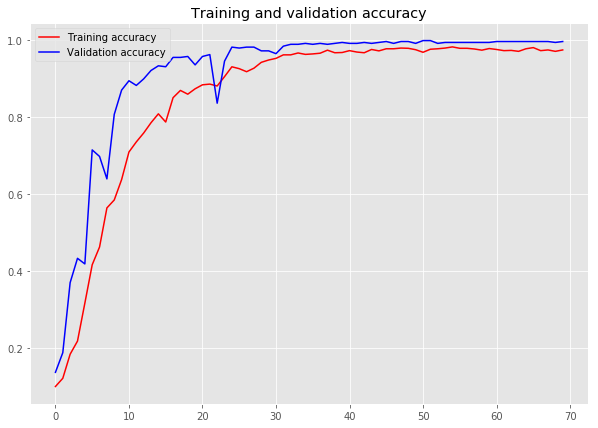

<Figure size 432x288 with 0 Axes>

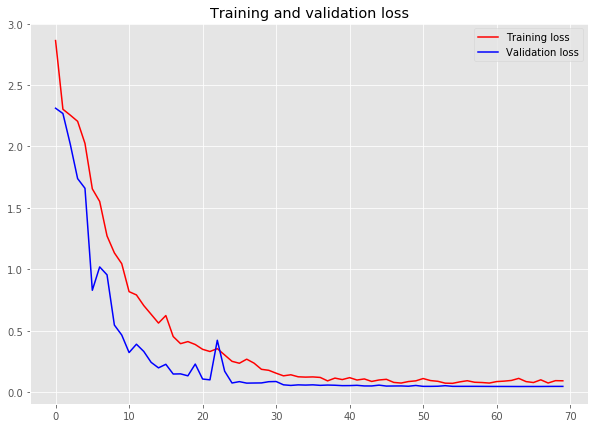

<Figure size 432x288 with 0 Axes>

In [18]:
%matplotlib inline
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(10,7))
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.legend(['Training accuracy','Validation accuracy'])
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(10,7))
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.legend(['Training loss','Validation loss'])
plt.figure()
max(val_acc) #the best validation accuracy the model have got

the above curves shows that there is no over fitting at all as the validation and the training curve almost stucking together ,even the model is doing better on the validation rather than the training .

**Confusion matrix and calssification report**
i conclude from precision that there are some images predicted to be one and three while they aren't.
also recall shows that there are some twos and threes images predicted as another numbers and it is clear that they are either ones or threes.

In [19]:
print("Classification report  \n%s\n"
      % ( metrics.classification_report(Y_test, model.predict_classes(X_test))))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(Y_test,model.predict_classes(X_test)))

Classification report  
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        46
         1.0       0.98      1.00      0.99        40
         2.0       1.00      0.98      0.99        45
         3.0       0.97      0.97      0.97        31
         4.0       1.00      1.00      1.00        38
         5.0       1.00      1.00      1.00        40
         6.0       1.00      1.00      1.00        52
         7.0       1.00      1.00      1.00        32
         8.0       1.00      1.00      1.00        50
         9.0       1.00      1.00      1.00        39

   micro avg       1.00      1.00      1.00       413
   macro avg       0.99      0.99      0.99       413
weighted avg       1.00      1.00      1.00       413


Confusion matrix:
[[46  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0]
 [ 0  0 44  1  0  0  0  0  0  0]
 [ 0  1  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  0  0  0  0 40  0  0  0  0]


**visualiziation for random sample from the validation data**

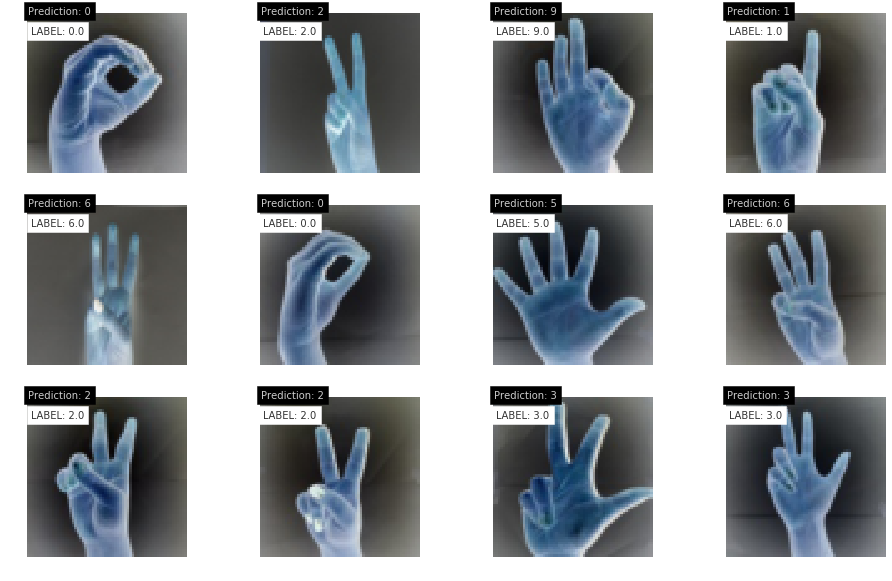

In [14]:
R = 3
C = 4
fig, axes = plt.subplots(R,C, figsize=(16,10))

for i in range(R):
    for j in range(C):
        r = np.random.randint(X_test.shape[0], size=1)[0]
        axes[i, j].imshow(X_test[r][:,:, :])
        axes[i, j].plot()
        #print('this is a', name[y_testo[r][0]], '-------- prediction is:', name[predicto[r]])
        axes[i, j].text(0, 0, 'Prediction: %s' % model.predict_classes(X_test)[r], color='w', backgroundcolor='k', alpha=0.8)
        axes[i, j].text(1,8, 'LABEL: %s' % Y_test[r][0], color='k', backgroundcolor='w', alpha=0.8)
        axes[i, j].axis('off')

**visualization for some images which wrongly classified**

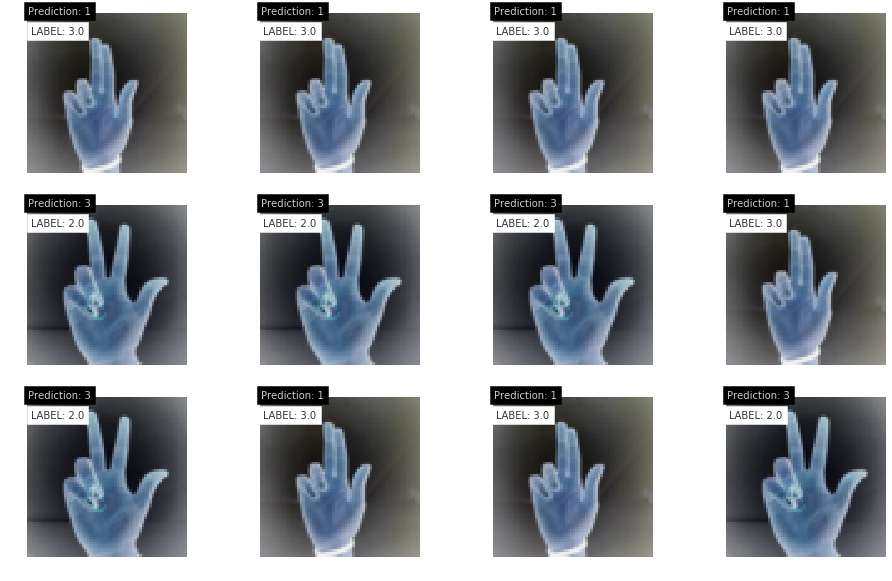

In [15]:
X_val = X_test
Y_val = Y_test
Y_pred_classes = model.predict_classes(X_val)
Y_pred_classes = Y_pred_classes.reshape(413,1)
errors = (Y_pred_classes - Y_val != 0)
errors_indicies = [i for i, x in enumerate(errors) if x]
Y_pred_classes_errors = Y_pred_classes[errors]
Y_true_errors = Y_val[errors]
X_val_errors = X_val[errors_indicies,:,:,:]

R = 3
C = 4
fig, axes = plt.subplots(R,C, figsize=(16,10))

for i in range(R):
    for j in range(C):
        r = np.random.randint(len(errors_indicies), size=1)[0]
        axes[i, j].imshow(X_val_errors[r][:,:, :])
        axes[i, j].plot()
        #print('this is a', name[y_testo[r][0]], '-------- prediction is:', name[predicto[r]])
        axes[i, j].text(0, 0, 'Prediction: %s' % Y_pred_classes_errors[r], color='w', backgroundcolor='k', alpha=0.8)
        axes[i, j].text(1,8, 'LABEL: %s' % Y_true_errors[r], color='k', backgroundcolor='w', alpha=0.8)
        axes[i, j].axis('off')

**loading the examples images to test the model **

In [16]:
examples_path = "../input/examples/examples/Examples/" 
examples = []
for data in listdir(examples_path):
    img = get_img(examples_path+'/'+data)
    examples.append(img)
examples = 1-np.array(examples).astype('float32')/255.

**testing the model while visualizing the output photos**

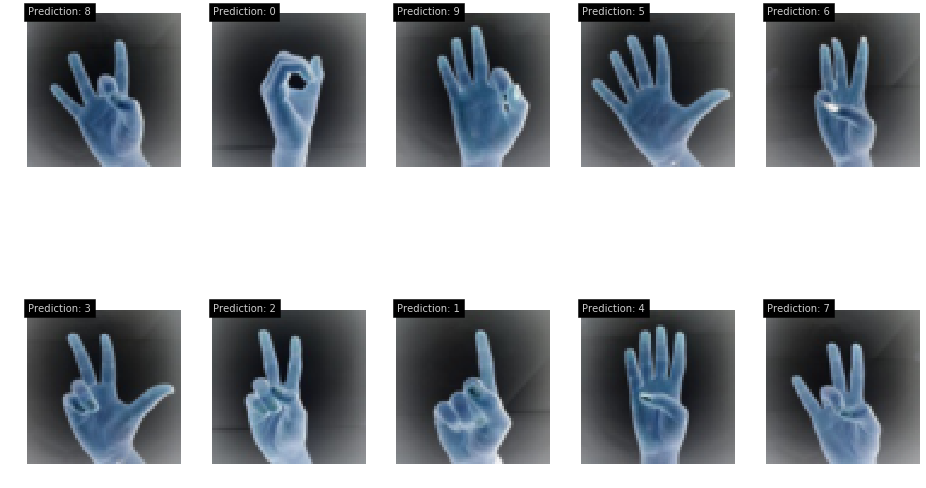

In [17]:
examples_pred = model.predict_classes(examples)

R = 2
C = 5
r = 0
fig, axes = plt.subplots(R,C, figsize=(16,10))
for i in range(R):
    for j in range(C):
        axes[i, j].imshow(examples[r][:,:, :])
        axes[i, j].plot()
        #print('this is a', name[y_testo[r][0]], '-------- prediction is:', name[predicto[r]])
        axes[i, j].text(0, 0, 'Prediction: %s' % examples_pred[r], color='w', backgroundcolor='k', alpha=0.8)
        #axes[i, j].text(1,8, 'LABEL: %s' % Y_true_errors[r], color='k', backgroundcolor='w', alpha=0.8)
        axes[i, j].axis('off')
        r+=1
        